<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/Prophet/By_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

import datetime
import holidays
from sklearn import preprocessing

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

# Methods

In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['ds','cat','y'], 
      parse_dates = True )
  df_doc['ds'] = pd.to_datetime(df_doc['ds'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['ds','y']].reset_index(drop=True)

In [0]:
def split_train_test(df_filter, date_start_test):
  split_point = df_filter[df_filter['ds']==date_start_test].index[0]
  train = df_filter[:split_point]
  test = df_filter[split_point:]
  return [train, test]

In [0]:
def compare_dates(date_begin, date_end, forecast, data):
  yhat = forecast[(forecast['ds'] >= date_begin) & (forecast['ds'] <= date_end)][['ds','yhat']]
  yreal = data[(data['ds'] >= date_begin) & (data['ds'] <= date_end)]
  merged_inner = pd.merge(left=yreal,right=yhat, left_on='ds', right_on='ds')
  return merged_inner

In [0]:
def get_df_holidays(year_list):
  us_holidays = holidays.UnitedStates()
  mylist = []
  for date, name in sorted(holidays.US(years=year_list).items()):
    mylist.append((name,date,-1,0))
  df_holidays = pd.DataFrame(mylist, columns = ['holiday' , 'ds', 'lower_window' , 'upper_window'])
  return df_holidays

In [0]:
def turn_week_to_date(yyyy,w):
    d = str(yyyy) + "-U" + str(w)
    r = datetime.datetime.strptime(d + '-0', "%Y-U%U-%w")
    return str(r.year) + '-' + str(r.month) + '-' + str(r.day)

# Data preparation

In [0]:
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
df_doc = read_raw_csv(url, 4167)
df_filter = filter_by(df_doc, 'Robert Caputo')
df_filter = df_filter.set_index(pd.DatetimeIndex(df_filter['ds']))

In [0]:
revenue_x_w = df_filter.groupby([df_filter.index.year, df_filter.index.week]).sum()
revenue_x_w['info'] = revenue_x_w.index
revenue_x_w = revenue_x_w.reset_index(drop=True)
revenue_x_w['ds'] = revenue_x_w['info'].apply(lambda x : turn_week_to_date(x[0],x[1]))
revenue_x_w = revenue_x_w.drop('info', axis=1)
revenue_x_w = revenue_x_w[['ds', 'y']]
revenue_x_w['ds'] = pd.to_datetime(revenue_x_w['ds'])

In [0]:
revenue_x_w = revenue_x_w[revenue_x_w['ds']<='2019-11-24']

In [0]:
y = revenue_x_w['y'].to_frame()
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
ds_df = revenue_x_w['ds'].to_frame()
y_df = pd.DataFrame({'y': y_scaled[:, 0]})
revenue_x_w_norm = pd.concat([ds_df, y_df], axis=1)

In [0]:
[train,test] = split_train_test(revenue_x_w_norm, '2019-09-01')

In [80]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,0.272429
185,2019-09-08,0.296705
186,2019-09-15,0.305939
187,2019-09-22,0.261846
188,2019-09-29,0.208416
189,2019-10-06,0.277284
190,2019-10-13,0.380026
191,2019-10-20,1.000000
192,2019-10-27,0.460856
193,2019-11-03,0.614997


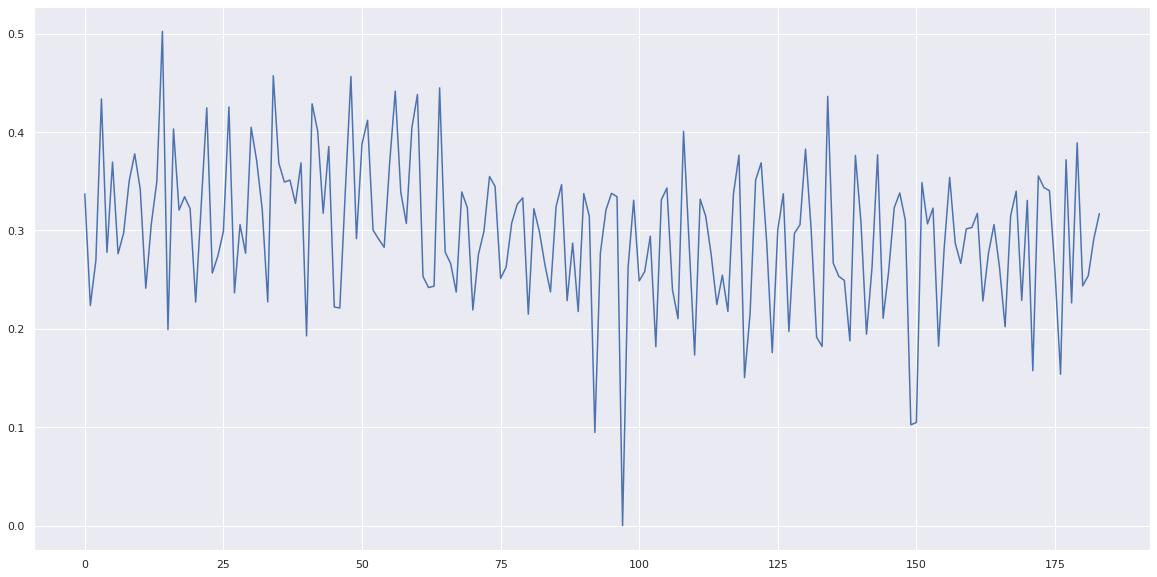

In [81]:
plt.plot(train['y'])

In [83]:
print(revenue_x_w_norm['y'].min())
print(revenue_x_w_norm['y'].mean())
print(revenue_x_w_norm['y'].median())
print(revenue_x_w_norm['y'].std())
print(revenue_x_w_norm['y'].max())

0.0
0.3056422613098504
0.3029565327337647
0.09789065828391755
1.0


# Simple Model

In [0]:
m = Prophet(weekly_seasonality=False,daily_seasonality=False)
m.fit(train)
future = m.make_future_dataframe(periods=13, freq='w')
forecast = m.predict(future)

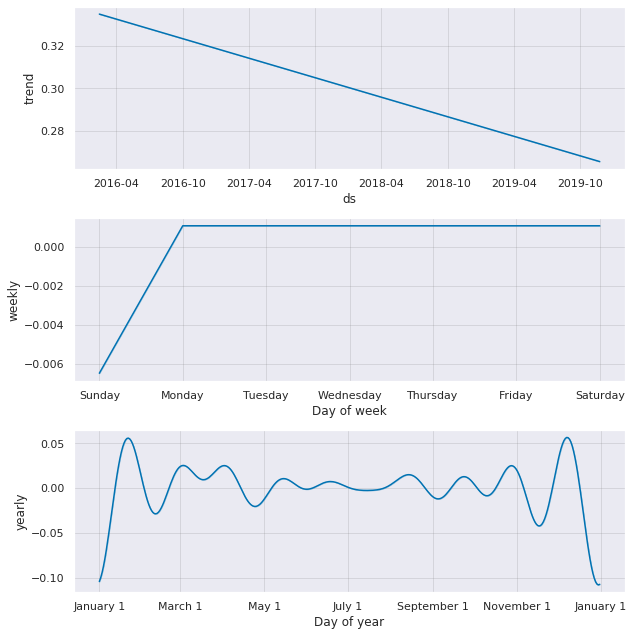

In [85]:
fig_decompose = m.plot_components(forecast)

In [86]:
compare_dates('2019-09-01', '2019-11-24', forecast, test)

,ds,y,yhat
0,2019-09-01,0.272429,0.253582
1,2019-09-08,0.296705,0.252194
2,2019-09-15,0.305939,0.263836
3,2019-09-22,0.261846,0.274244
4,2019-09-29,0.208416,0.269933
5,2019-10-06,0.277284,0.256571
6,2019-10-13,0.380026,0.253840
7,2019-10-20,1.000000,0.269489
8,2019-10-27,0.460856,0.284777
9,2019-11-03,0.614997,0.274167


# Fourier Model order 5

In [87]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,0.272429
185,2019-09-08,0.296705
186,2019-09-15,0.305939
187,2019-09-22,0.261846
188,2019-09-29,0.208416
189,2019-10-06,0.277284
190,2019-10-13,0.380026
191,2019-10-20,1.000000
192,2019-10-27,0.460856
193,2019-11-03,0.614997


In [0]:
m1 = Prophet(
    weekly_seasonality=False, 
    daily_seasonality=False)
m1.add_seasonality(
    name='weekly', 
    period=5, 
    fourier_order=5)
m1.fit(train)
future1 = m1.make_future_dataframe(periods=13, freq='W')
forecast1 = m1.predict(future1)

In [91]:
compare_dates('2019-09-01', '2019-11-24', forecast1, test)

,ds,y,yhat
0,2019-09-01,0.272429,0.246388
1,2019-09-08,0.296705,0.249427
2,2019-09-15,0.305939,0.240563
3,2019-09-22,0.261846,0.280280
4,2019-09-29,0.208416,0.292094
5,2019-10-06,0.277284,0.252113
6,2019-10-13,0.380026,0.251951
7,2019-10-20,1.000000,0.245332
8,2019-10-27,0.460856,0.289811
9,2019-11-03,0.614997,0.296438


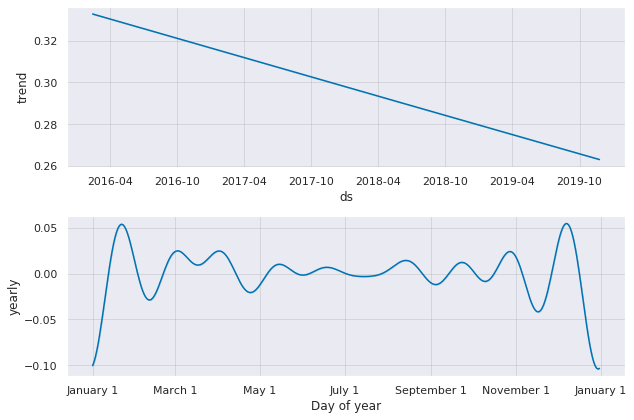

In [118]:
fig_decompose = m.plot_components(forecast1)

# With Holidays

In [93]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,0.272429
185,2019-09-08,0.296705
186,2019-09-15,0.305939
187,2019-09-22,0.261846
188,2019-09-29,0.208416
189,2019-10-06,0.277284
190,2019-10-13,0.380026
191,2019-10-20,1.000000
192,2019-10-27,0.460856
193,2019-11-03,0.614997


In [0]:
df_holidays = get_df_holidays([2016,2017,2018,2019])
m2 = Prophet(holidays=df_holidays,daily_seasonality=False,weekly_seasonality=True)
m2.add_country_holidays(country_name='US')
m2.fit(train)
future2 = m2.make_future_dataframe(periods=13, freq='W')
forecast2 = m2.predict(future2)

In [111]:
compare_dates('2019-09-01', '2019-11-24', forecast2, test)

,ds,y,yhat
0,2019-09-01,0.272429,0.220728
1,2019-09-08,0.296705,0.274862
2,2019-09-15,0.305939,0.277462
3,2019-09-22,0.261846,0.263963
4,2019-09-29,0.208416,0.237016
5,2019-10-06,0.277284,0.216495
6,2019-10-13,0.380026,0.322268
7,2019-10-20,1.000000,0.251807
8,2019-10-27,0.460856,0.277268
9,2019-11-03,0.614997,0.271390


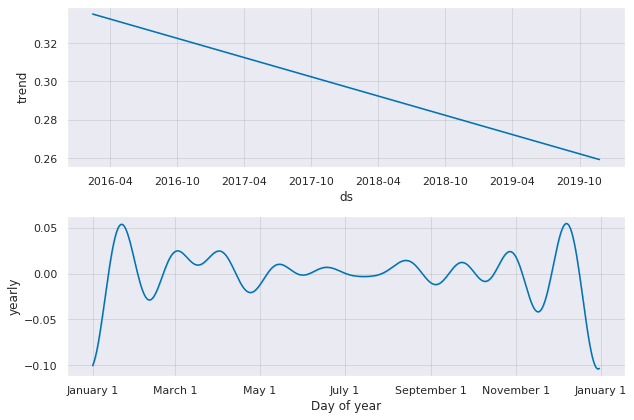

In [119]:
fig_decompose = m.plot_components(forecast2)

# Compare Models

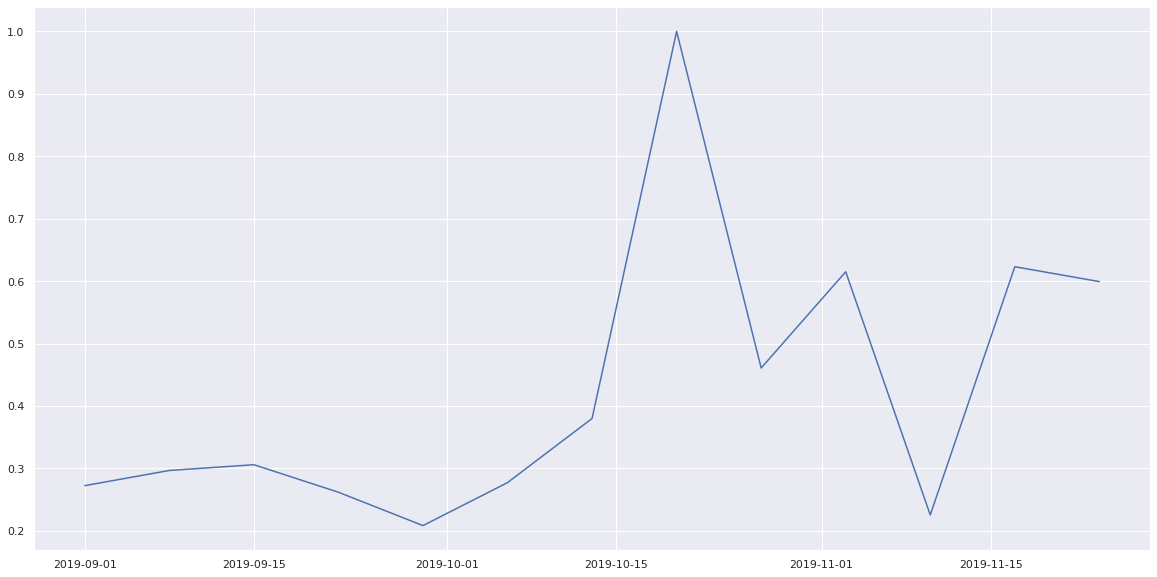

In [100]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(revenue_x_w_norm[revenue_x_w_norm['ds'] >= '2019-09-01']['ds'], revenue_x_w_norm[revenue_x_w_norm['ds'] >= '2019-09-01']['y'], label='y')

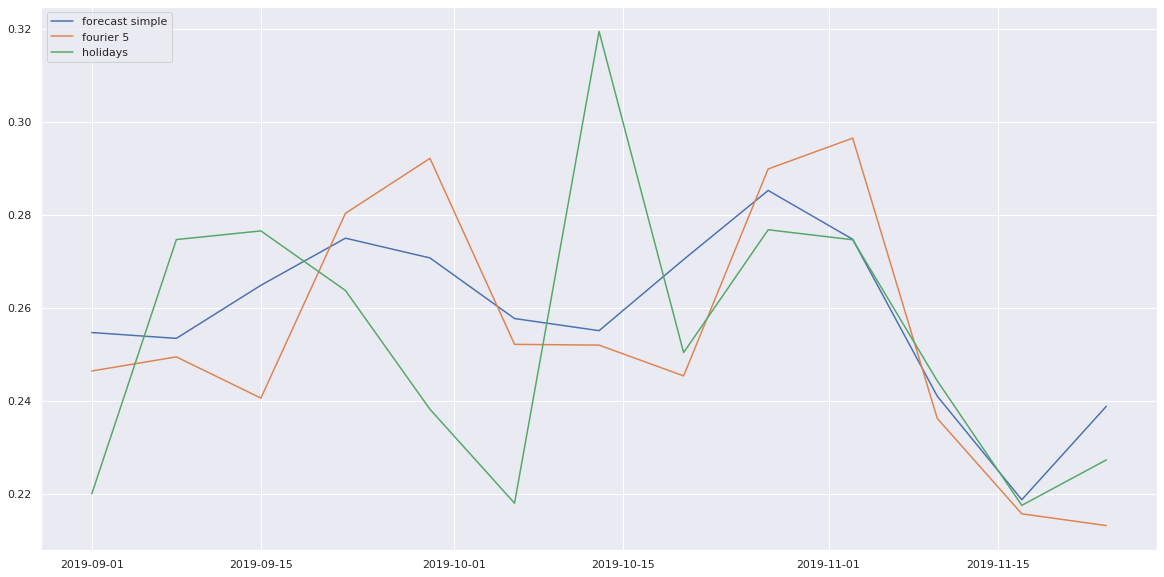

In [120]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(forecast[forecast['ds'] >= '2019-09-01']['ds'], forecast[forecast['ds'] >= '2019-09-01']['yhat'], label='forecast simple')
plt.plot(forecast1[forecast1['ds'] >= '2019-09-01']['ds'], forecast1[forecast1['ds'] >= '2019-09-01']['yhat'], label='fourier 5')
plt.plot(forecast2[forecast2['ds'] >= '2019-09-01']['ds'], forecast2[forecast2['ds'] >= '2019-09-01']['yhat'], label='holidays')
plt.legend(loc="upper left")

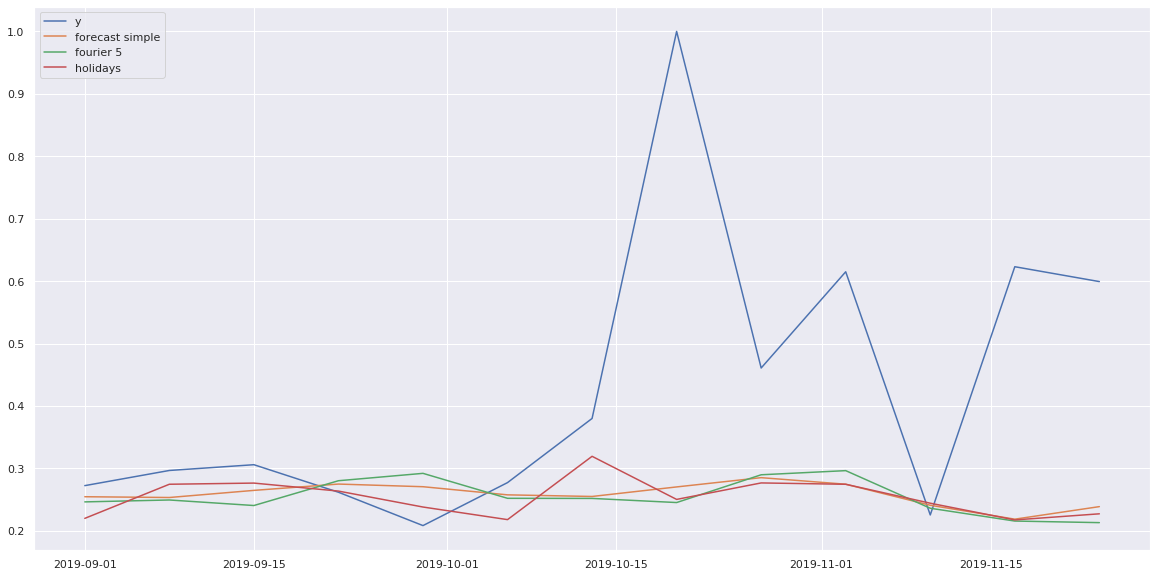

In [121]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(revenue_x_w_norm[revenue_x_w_norm['ds'] >= '2019-09-01']['ds'], revenue_x_w_norm[revenue_x_w_norm['ds'] >= '2019-09-01']['y'], label='y')
plt.plot(forecast[forecast['ds'] >= '2019-09-01']['ds'], forecast[forecast['ds'] >= '2019-09-01']['yhat'], label='forecast simple')
plt.plot(forecast1[forecast1['ds'] >= '2019-09-01']['ds'], forecast1[forecast1['ds'] >= '2019-09-01']['yhat'], label='fourier 5')
plt.plot(forecast2[forecast2['ds'] >= '2019-09-01']['ds'], forecast2[forecast2['ds'] >= '2019-09-01']['yhat'], label='holidays')
plt.legend(loc="upper left")